<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/large_learning_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Core Code

In [ ]:
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

USE_CUDA = False
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device:', device)

Version 1.5.1+cu101
CUDA enabled: True
Using device: cpu


#### Network Definition

In [ ]:
class fc_net(nn.Module):
    def __init__(self, network_params):
        super().__init__()
        self.width = network_params['width']
        self.length = network_params['length']
        self.input_dim = network_params['input_dim']
        self.activation = network_params['activation']
        self.bias = network_params['bias']
      
        self.fc_u = nn.Linear(self.input_dim, self.width, bias=self.bias)
        self.fc_v = nn.Linear(self.width, 1, bias=self.bias)

        # Initializes weights to N(0,1) (default is Xavier)
        nn.init.normal_(self.fc_u.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc_v.weight, mean=0.0, std=1.0)
        if self.bias:
            nn.init.normal_(self.fc_u.bias, mean=0.0, std=np.sqrt(self.width))
            nn.init.normal_(self.fc_v.bias, mean=0.0, std=np.sqrt(self.width))
        
        if self.length > 1:
            self.fc_w1 = nn.Linear(self.width, self.width, bias=self.bias)
            nn.init.normal_(self.fc_w1.weight, mean=0.0, std=1.0)
            if self.bias:
                nn.init.normal_(self.fc_w1.bias, mean=0.0, std=np.sqrt(self.width))
        if self.length > 2:
            self.fc_w2 = nn.Linear(self.width, self.width, bias=self.bias)
            nn.init.normal_(self.fc_w2.weight, mean=0.0, std=1.0)
            if self.bias:
                nn.init.normal_(self.fc_w2.bias, mean=0.0, std=self.np.sqrt(self.width))
        
        if self.activation == 'Identity':
            self.act = nn.Identity()
        elif self.activation == 'ReLU':
            self.act = nn.ReLU()
        elif self.activation == 'Tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError('Activation not implemented!')
        # self.act2 = nn.Identity()

    def forward(self, x):
        preact1 = 1 / np.sqrt(self.input_dim) * self.fc_u(x)
        postact1 = self.act(preact1)
        # x = self.act2(1 / np.sqrt(self.input_dim) * x)
        if self.length == 1:
            out = self.fc_v(postact1)
            hl_vals = [preact1, postact1]
        elif self.length > 1:
            preact2 = 1 / np.sqrt(self.width) * self.fc_w1(postact1)
            postact2 = self.act(preact2)
            # x = self.act2(1 / np.sqrt(self.width) * x)

            out = self.fc_v(postact2)
            hl_vals = [preact1, postact1, preact2, postact2]
        if self.length > 2:
            preact2 = 1 / np.sqrt(self.width) * self.fc_w1(postact1)
            postact2 = self.act(preact2)
            preact3 = 1 / np.sqrt(self.width) * self.fc_w2(postact2)
            postact3 = self.act(preact3)

            out = self.fc_v(postact3)
            hl_vals = [preact1, postact1, preact2, postact2, preact3, postact3]
                
        return 1 / np.sqrt(self.width) * out, hl_vals   

#### NTK Calculation

In [ ]:
def ntk_auto(x, net):
  n_train = x.shape[0]
  ntk_val = np.zeros((n_train, n_train))

  GRAD_FIRST = True
  
  if GRAD_FIRST: # Calculates all gradients first, this might not work for large datasets
    outs = []
    grads = []
    for sample in range(x.size()[0]): # iterate over batch index
      out_for_sample, _ = net(x[sample,:])
      outs.append(out_for_sample)
      
      grads_for_sample = []
      for param_it in range(len(list(net.parameters()))):
        if list(net.parameters())[param_it].requires_grad: # only accesses gradients if they are calculated
          grad_val = torch.flatten(torch.autograd.grad(out_for_sample, list(net.parameters())[param_it], retain_graph=True)[0])
          grads_for_sample.append(grad_val)
      grads.append(grads_for_sample)
        
      # Calculation of ntk using gradients
    for sample1 in range(0, x.size()[0]): # iterate over batch index
      out1 = outs[sample1]
      for sample2 in range(0, x.size()[0]):
        out2 = outs[sample2]
        
        if sample1 > sample2: # NTK is symmetric, so doesn't recalculate these
          ntk_val[sample1][sample2] = ntk_val[sample2][sample1]
        else:
          for param_it in range(len(list(net.parameters()))):
            if list(net.parameters())[param_it].requires_grad: # only adds if gradient is calculated
              grads1 = grads[sample1][param_it]
              grads2 = grads[sample2][param_it]
              ntk_val[sample1][sample2] += torch.matmul(grads1, grads2).cpu().data.numpy()
  
  else: # Calculate gradients in real time, this is less efficient
    for sample1 in range(0, x.size()[0]): # iterate over batch index
      out1, _ = net(x[sample1,:])
      for sample2 in range(0, x.size()[0]):
        out2, _ = net(x[sample2,:])

        if sample1 > sample2: # NTK is symmetric, so doesn't recalculate these
          ntk_val[sample1][sample2] = ntk_val[sample2][sample1]
        else:
          for param_it in range(len(list(net.parameters()))):
            grads1 = torch.autograd.grad(out1, list(net.parameters())[param_it], retain_graph=True)
            grads2 = torch.autograd.grad(out2, list(net.parameters())[param_it], retain_graph=True)
            ntk_val[sample1][sample2] += torch.matmul(torch.flatten(grads1[0]),torch.flatten(grads2[0])).cpu().data.numpy()

  ntk_val = 1/n_train * ntk_val

  return ntk_val

#### Training

In [ ]:
def train(train_data, train_params, network_params):
  """ Runs a single training example """
  
  # Unpacks train_data
  X, y = train_data[:][0], train_data[:][1]
  # Unpacks training parameters
  lr = train_params['lr']
  epochs = train_params['epochs']
  loss_type = train_params['loss']
  batch_size = train_params['batch_size']
  var_lr = train_params['var_lr']
  # Unpacks network parameters
  length = network_params['length']
  width = network_params['width']
  input_dim = network_params['input_dim']

  n_train = train_data[:][0].shape[0]
  steps = int(n_train/batch_size) * epochs

  # Values to be tracked during training
  f_trial = np.zeros((steps, n_train))
  ntk_trial  = np.zeros((steps, n_train, n_train))
  loss_trial  = np.zeros((steps))
  dead_neuron_trial  = np.zeros((length, steps))
  dead_neuron_idx = np.zeros((length, width))
  align_trial  = np.zeros((steps, length+1))
  initial_state_trial = np.zeros((2, width))

  net =  fc_net(network_params).to(device)



  # if train_params['w_const']:
  #   net.fc_w1.weight.requires_grad = False
  if train_params['w_const']:
    params = list(net.fc_u.parameters()) + list(net.fc_v.parameters())
    optimizer = optim.SGD(params, lr=lr)
  else:
    optimizer = optim.SGD(net.parameters(), lr=lr)

  for epoch in range(epochs):
    for batch in range(0, len(X), batch_size):
                
      step = int(n_train/batch_size) * epoch + batch
                
      batch_X = X[batch:batch + batch_size]
      batch_y = y[batch:batch + batch_size]
                                   
      net.zero_grad()

      output, act_vals = net(batch_X)

      f = output.data.cpu().numpy()[:,0]

      # Finds losses and dL/df (lprime) for various losses
      if loss_type == 'MSE':
          y_val = [val[0] for val in batch_y.cpu().data.numpy()]
          # MSE loss is (f(x)-y)^2 so need np.sqrt(2) in order to map to 1/2*(f(x)-y)^2
          loss = F.mse_loss(1/np.sqrt(2)*output, 1/np.sqrt(2)*batch_y, reduction='mean')
          lprime = 1/n_train * (f-y_val)
      elif loss_type == 'XE':
          y_val = batch_y.cpu().data.numpy()[:]
          # Effectively turns single-output cross entropy into two-output for softmax
          out = torch.stack([-1/2 * output.view(batch_size), 1/2 * output.view(batch_size)], dim=1)
          loss = F.cross_entropy(out, batch_y)
          lprime = np.zeros(batch_size)
          for sample in range(batch_size):
              out = f[sample]
              if batch_y[sample] == 0:
                  lprime[sample] = 1/n_train * 1/(1+np.exp(-out))
              elif batch_y[sample] == 1:
                  lprime[sample] = -1/n_train * 1/(1+np.exp(out))
          lprime_mse = 1/n_train * (f-y_val)
      else:
          raise ValueError("Loss not implemented")

      loss.backward()

      # Variable Learning Rate
      if var_lr:
        # Amount the learning_rate should be adjusted
        val = np.sum(lprime_mse)/np.sum(lprime)
        adjust_learning_rate(optimizer, lr_init, val)

      ntk_array = ntk_auto(X, net) 
      
      with torch.no_grad(): # doesn't track gradients through below calculations
        # Dead Neuron Calculation
        if network_params['activation'] == 'ReLU':
          dead_neuron_trial[:,step], dead_neuron_idx = dead_neuron_calcs(act_vals, net, train_params, network_params)
        if epoch == 0:
          initial_state_trial = np.copy(initial_state_vals(act_vals, net, train_params, network_params))
          if length > 1:
            initial_preacts = np.copy(initial_state_vals_mod(act_vals, net, train_params, network_params))
          else:
            initial_preacts = 0
        # align_trial[step] = alignments_calc(act_vals, net, train_params, network_params)

      f_trial[step] = f
      ntk_trial[step] = ntk_array
      loss_trial[step] = loss

      # print(net.fc_w1.weight.data[:2])
      
      optimizer.step()
  
  train_trial_outs = {'f_trial': f_trial, 'ntk_trial': ntk_trial, 'loss_trial': loss_trial, 
                      'dead_neuron_trial': dead_neuron_trial, 'initial_state': initial_state_trial,
                      'dead_neuron_idx': dead_neuron_idx, 'align_trial': align_trial, 'initial_preact': initial_preacts}

  return train_trial_outs

def train_trials(train_data, train_params, network_params):
  """ Runs many training examples """

  n_train = train_data[:][0].shape[0]
  trials = train_params['trials']
  epochs = train_params['epochs']
  batch_size = train_params['batch_size']
  steps = int(n_train/batch_size) * epochs

  length = network_params['length']
  width = network_params['width']

  fs = np.zeros((trials, steps, n_train))
  ntks = np.zeros((trials, steps, n_train, n_train))
  losses = np.zeros((trials, steps))
  dead_neurons = np.zeros((trials, length, steps))
  align = np.zeros((trials, steps, length+1))
  initial_states = [] # only keeps u and v inits
  dead_neuron_idxs = []
  f0s = []
  lam0s = []
  rand_preact0 = []

#     for trial in tqdm(range(TRIALS)):
  for trial in range(trials):
    train_trial_outs = train(train_data, train_params, network_params)
    fs[trial] = train_trial_outs['f_trial']
    ntks[trial] = train_trial_outs['ntk_trial']
    losses[trial] = train_trial_outs['loss_trial']
    dead_neurons[trial] = train_trial_outs['dead_neuron_trial']
    align[trial] = train_trial_outs['align_trial']
    
    initial_states.append(train_trial_outs['initial_state'])
    dead_neuron_idxs.append(train_trial_outs['dead_neuron_idx'])
    f0s.append(train_trial_outs['f_trial'][0])
    eig0s = np.linalg.eigvals(train_trial_outs['ntk_trial'][0])
    lam0s.append(np.amax(eig0s))
    rand_preact0.append(train_trial_outs['initial_preact'])

  # Dictionary to hold various training parameters    
  train_outputs = dict()

  # Averages quantities over all trials
  train_outputs['fs'] = 1 / trials * np.sum(np.abs(fs), axis=0)
  train_outputs['ntks'] = 1 / trials * np.sum(ntks, axis=0)
  train_outputs['losses'] = 1 / trials * np.sum(losses, axis=0)
  train_outputs['dead_neurons'] = 1 / trials * np.sum(dead_neurons, axis=0)
  train_outputs['align'] = 1 / trials * np.sum(align, axis=0)
  train_outputs['initial_states'] = initial_states
  train_outputs['dead_neuron_idx'] = dead_neuron_idxs
  train_outputs['f0s'] = f0s
  train_outputs['lam0s'] = lam0s
  train_outputs['preact0'] = rand_preact0

  return train_outputs

#### Other Functions

In [ ]:
def default_params(train_data, train_params, network_params):
  """ Sets the defaults of many parameters if not specified"""
  if 'batch_size' not in train_params: train_params['batch_size'] = train_data.shape[0]
  if 'var_lr' not in train_params: train_params['var_lr'] = False

  if 'activation' not in network_params: network_params['activation'] = 'Identity'
  if 'bias' not in network_params: network_params['bias'] = 'False'

  return train_params, network_params

def dead_neuron_calcs(act_vals, net, train_params, network_params):

  width = network_params['width']
  length = network_params['length']
  input_dim = network_params['input_dim']

  batch_size = train_params['batch_size']
  if batch_size > 1:
    # Need to redefine what it means to be alive for more than one training set
    raise NotImplementedError

  alive_idxs = np.zeros((length, width))
  num_alive = np.zeros((length))

  preact1 = act_vals[0].data.cpu().numpy().flatten()

  alive_idxs[0] = [1 if preact > 0 else 0 for preact in preact1]
  num_alive[0] = np.sum(alive_idxs[0])

  if length > 1:
    preact2 = act_vals[2].data.cpu().numpy().flatten()
    
    alive_idxs[1] = [1 if preact > 0 else 0 for preact in preact2]
    num_alive[1] = np.sum(alive_idxs[1])

  if length > 2:
    preact3 = act_vals[4].data.cpu().numpy().flatten()
    
    alive_idxs[2] = [1 if preact > 0 else 0 for preact in preact3]
    num_alive[2] = np.sum(alive_idxs[2])
  
  perc_dead = [1- 1/(width * batch_size) * alive for alive in num_alive]

  return perc_dead, alive_idxs

def alignments_calc(act_vals, net, train_params, network_params):
  """ Calculates how much a weight vector/matrix aligns with its update"""

  length = network_params['length']

  ui = net.fc_u.weight.data.cpu().numpy()[:,0]
  vi = net.fc_v.weight.data.cpu().numpy()[0]
  if length == 1:
      v_diff = np.abs(np.dot(vi,ui)/np.sqrt(np.dot(vi,vi) * np.dot(ui,ui)))
      u_diff = np.abs(np.dot(ui,vi)/np.sqrt(np.dot(vi,vi) * np.dot(ui,ui)))

      align_angles = [v_diff, u_diff]
  elif length == 2:
      preact1 = act_vals[0].data.cpu().numpy().flatten()
      preact2 = act_vals[2].data.cpu().numpy().flatten()
      postact2 = act_vals[3].data.cpu().numpy().flatten()

      wij = net.fc_w1.weight.data.cpu().numpy()
      
      wu = np.matmul(wij, ui)
      vw = np.matmul(vi, wij)
      v_diff = np.abs(np.dot(vi,postact2)/np.sqrt(np.dot(vi,vi) * np.dot(postact2, postact2)))
      u_diff = np.abs(np.dot(vw,ui)/np.sqrt(np.dot(vw,vw) * np.dot(ui,ui)))
      
      w_flat = wij.flatten()
      vu_flat = np.outer(vi,ui).flatten()
      w_diff = np.abs(np.dot(vu_flat,w_flat)/np.sqrt(np.dot(vu_flat,vu_flat) * np.dot(w_flat,w_flat)))
      
      align_angles = [v_diff, w_diff, u_diff]
      # ntk_comp_mags[trial][step] = [1/(WIDTH**2)*np.dot(wu,wu), 1/(WIDTH**2)*np.dot(vi,vi)*np.dot(ui,ui), 
      #                               1/(WIDTH**2)*np.dot(vw,vw)]
      # weight_mags[trial][step] = [np.sqrt(np.dot(vi,vi)), np.sqrt(1/WIDTH*np.dot(w_flat,w_flat)), np.sqrt(np.dot(ui,ui)),
      #                             np.sqrt(1/WIDTH*np.dot(wu, wu)), np.sqrt(1/WIDTH*np.dot(vw, vw))]
  
  return align_angles

def initial_state_vals(act_vals, net, train_params, network_params):

  width = network_params['width']
  length = network_params['length']

  if length == 1:
    return np.array([net.fc_u.weight.data.cpu().view(width).numpy(), net.fc_v.weight.data.cpu().view(width).numpy()])
  elif length ==2:
    # u_mult = np.zeros(width)
    
    # preact2 = np.copy(act_vals[2].data.cpu().numpy()).flatten()
    # alive2 = [1 if preact > 0 else 0 for preact in preact2]
    # vi = np.copy(net.fc_v.weight.data.cpu().view(width).numpy())
    # wij = np.copy(net.fc_w1.weight.data.cpu().numpy())
    # v_alive = np.array([v_value * alive for v_value, alive in zip(vi, alive2)])
    # u_mult = np.copy(np.matmul(v_alive, wij))
    # # u_mult = np.copy(np.matmul(vi, wij))

    # return np.array([net.fc_u.weight.data.cpu().view(width).numpy(), u_mult])

    v_mult = np.zeros(width)
    
    preact2 = np.copy(act_vals[2].data.cpu().numpy())
    v_mult = preact2

    return np.array([v_mult, net.fc_v.weight.data.cpu().view(width).numpy()])


def initial_state_vals_mod(act_vals, net, train_params, network_params):

  width = network_params['width']
  length = network_params['length']

  random_neuron_idx = 5

  v_mult = np.zeros(width)

  preact1 = act_vals[0].data.cpu().numpy().flatten()
  preact2 = np.copy(act_vals[2].data.cpu().numpy().flatten())

  alive1 = [1 if preact > 0 else 0 for preact in preact1]
  wij = np.copy(net.fc_w1.weight.data.cpu().numpy())
  wij_alive = np.matmul(wij, alive1)

  return np.array(preact2[random_neuron_idx])


### Experiments

#### Run Multiple Learning Rates

In [ ]:
def test_multiple_lrs(train_data, train_params, network_params, result_params):
  """ Runs training trials for a variety of learning_rates """
  
  results = {'fs': [], 'lams': [], 'ntks': [], 'losses': [], 'dead_neurons': [], 'lr_epochs': [], 'initial_states': [],
             'dead_neuron_idx': [], 'f0s': [], 'lam0s': [], 'preact0': []}

  lr_vals = train_params['lr_vals']

  for lr_idx in range(len(lr_vals)):
    if train_params['physical_time']:
        epochs_val = int(np.ceil(train_params['physical_time_cap']/lr_vals[lr_idx]))
    else:
        epochs_val = train_params['epochs']
    
    steps_val = epochs_val * train_data[:][0].shape[0]/train_params['batch_size']
    results['lr_epochs'].append(epochs_val)

    print("Running LR:", lr_vals[lr_idx], " for ", steps_val, ' steps (', epochs_val, " epochs).")
    
    train_params['lr'] = lr_vals[lr_idx]
    train_outputs = train_trials(train_data, train_params, network_params)

    results['fs'].append(train_outputs['fs'])
    results['ntks'].append(train_outputs['ntks'])
    results['losses'].append(train_outputs['losses'])
    results['dead_neurons'].append(train_outputs['dead_neurons'])
    results['initial_states'].append(train_outputs['initial_states'])
    results['dead_neuron_idx'].append(train_outputs['dead_neuron_idx'])
    results['f0s'].append(train_outputs['f0s'])
    results['lam0s'].append(train_outputs['lam0s'])
    results['preact0'].append(train_outputs['preact0'])
      
    # Calculates properties of the ntk and extracts first f component
    try:
      eigs = np.linalg.eigvals(train_outputs['ntks'])
      results['lams'].append(np.amax(eigs, axis=1))
    except:
      print('Error while trying to calculated lambda values.')
      results['lams'].append(['nan'])
    

  # Analyze dead neurons
  # analyze_dead_neurons(results, train_params, network_params, result_params)
  # Plots the data
  if len(result_params['plots']) > 0:
    plot_results(results, train_params, network_params, result_params)

##### Dead Neuron Analysis

In [ ]:
def analyze_dead_neurons(results, train_params, network_params, result_params):
  for lr_idx in range(len(train_params['lr_vals'])):
    n_alive1 = []
    n_alive2 = []
    n_survive = 0
    for trial in range(train_params['trials']):
      n_alive1_trial = np.sum(results['dead_neuron_idx'][lr_idx][trial][0])
      n_alive1.append(n_alive1_trial)
      n_alive2_trial = np.sum(results['dead_neuron_idx'][lr_idx][trial][1])
      n_alive2.append(n_alive2_trial)
      if n_alive2_trial > 0: n_survive += 1

    print('LR', train_params['lr_vals'][lr_idx],' - perc survive:', n_survive/train_params['trials'])
    print('LR', train_params['lr_vals'][lr_idx],' - # neurons alive:', [(n_alive1[x], n_alive2[x]) for x in list(range(len(n_alive1))) if n_alive2[x] > 0])

#### Neuron Survival Tests

In [ ]:
def neuron_surivival(train_data, train_params, network_params, result_params):
  """ Analyzes what makes a network's neurons survive for a sngle learning rate """
  
  results = {'fs': [], 'lams': [], 'ntks': [], 'losses': [], 'dead_neurons': [], 'lr_epochs': [], 'initial_states': [],
             'dead_neuron_idx': [], 'f0s': [], 'lam0s': []}

  lr_vals = train_params['lr_vals']
  if len(lr_vals) > 1:
    raise ValueError('Not implemented for multiple learning rates')
  train_params['lr'] = lr_vals[0]

  trials = train_params['trials']
  length = network_params['length']

  plt.figure(figsize=[12.8, 9.6])

  plt.suptitle(train_params['loss'] + ' Loss - ' + network_params['activation'] + ' L=' + str(network_params['length']) +
               ' Model, BIAS: ' + str(network_params['bias'] ), fontsize=16)
  plt.figtext(.5,.925,'LR:' + str(train_params['lr']) + ', Width: ' + str(network_params['width'] ) + ', Trials: ' + str(train_params['trials']) + ', Training Ex: ' + str()
              + str(train_params['n_train']), fontsize=12, ha='center')
  
  ax1 = plt.subplot('221')
  ax2 = plt.subplot('222')
  ax3 = plt.subplot('223')
  ax4 = plt.subplot('224')
  ax1.set_xlabel('Step')
  ax2.set_xlabel('Step')
  ax3.set_xlabel('Step')
  ax4.set_xlabel('Step')
  ax1.set_ylabel('|f|')
  ax2.set_ylabel('|f|')
  ax3.set_ylabel('HL 1 Dead Neuron Perc')
  ax4.set_ylabel('Lambda')
  x_plot = list(range(train_params['epochs']))

  # ax1.set_ylim([0, 50])
  # ax2.set_ylim([0, 10])
  ax2_limit = 11
  ax3.axhline(1, color='k', linestyle='--')
  # ax4.set_ylim([0, 1.1])
  ax4.axhline(1, color='k', linestyle='--')

  for trial in range(trials):
    train_trial_outs = train(train_data, train_params, network_params)
    print('Number of alive neurons:', np.sum(train_trial_outs['dead_neuron_idx']))
    
    eigs = np.linalg.eigvals(train_trial_outs['ntk_trial'])
    lam = np.amax(eigs, axis=1)

    plt_color = 'b' if np.sum(train_trial_outs['dead_neuron_idx']) > 0 else 'r'
    
    # ax1.plot(x_plot, train_trial_outs['f_trial'], c=plt_color)
    ax1.plot(x_plot, np.abs(train_trial_outs['f_trial']), c=plt_color)
    ax2.plot(x_plot[:ax2_limit], train_trial_outs['f_trial'][:ax2_limit], c=plt_color)
    ax3.plot(x_plot, train_trial_outs['dead_neuron_trial'][length-1], c=plt_color)
    ax4.plot(x_plot, lam, c=plt_color)
    # ax4.plot(x_plot, [x[0] for x in train_trial_outs['align_trial']], c=plt_color)
    # ax4.plot(x_plot, train_trial_outs['dead_neuron_trial'][0], c=plt_color)

  plt.show()



#### Plots Data

In [ ]:
def plot_results(results, train_params, network_params, result_params):
  """ Plots all the things"""
  
  plots = result_params['plots']
  num_sub_figs = len(plots)
  lr_vals = train_params['lr_vals']
  length = network_params['length']

  sbpltnums = subplot_nums(num_sub_figs)
  if num_sub_figs > 4:
    plt.figure(figsize=[1.5* 12.8, 9.6])
  else:
    plt.figure(figsize=[12.8, 9.6])

  colors = ['r', 'tab:orange', 'y', 'g', 'c', 'b',  'm', 'tab:Brown', 'k']

  # x Axis generation
  x_plot = []
  if train_params['physical_time']:
    x_label_str = 'Eta * Step'
    for lr_idx in range(len(lr_vals)):
      x_plot.append([lr_vals[lr_idx]*i for i in list(range(lr_epochs[lr_idx]))])
  else:
    x_label_str = 'Step'
    for lr_idx in range(len(lr_vals)):
      x_plot.append(list(range(train_params['epochs'])))
  
  plt.suptitle(train_params['loss'] + ' Loss - ' + network_params['activation'] + ' L=' + str(network_params['length']) +
               ' Model, BIAS: ' + str(network_params['bias'] ), fontsize=16)
  plt.figtext(.5,.925,'Width: ' + str(network_params['width'] ) + ', Trials: ' + str(train_params['trials']) + ', Training Ex: ' + str()
              + str(train_params['n_train']), fontsize=12, ha='center')
  # plt.figtext(.5, .895, 'Batch size:' + str(BATCH_SIZE), fontsize=12, ha='center')

  subplot_count = 0
  # Loss vs step subplot
  if 'Loss' in plots: 
    ax1 = plt.subplot(sbpltnums[subplot_count])
  #   ax1.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      ax1.plot(x_plot[lr_idx], results['losses'][lr_idx], c=colors[lr_idx], marker='o')
    ax1.set_xlabel(x_label_str)
    ax1.set_ylabel('Loss')
    ax1.legend(lr_vals)
    subplot_count += 1
  
  # Lambda vs step subplot
  if 'Lambda' in plots:
    ax2 = plt.subplot(sbpltnums[subplot_count])
  #   ax2.set_ylim([-0.05, 0.25])
    for lr_idx in range(len(lr_vals)):
      ax2.plot(x_plot[lr_idx], results['lams'][lr_idx], c=colors[lr_idx], marker='o')
    ax2.set_xlabel(x_label_str)
    ax2.set_ylabel('Lambda')
    ax2.legend(lr_vals)
    subplot_count += 1

  # Dead_neuron_perc vs step subplot
  if 'Dead_neuron_perc' in plots: 
    ax3 = plt.subplot(sbpltnums[subplot_count])
  #   ax3.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      ax3.plot(x_plot[lr_idx], results['dead_neurons'][lr_idx][0], c=colors[lr_idx], marker='o')
    ax3.set_xlabel(x_label_str)
    ax3.set_ylabel('Dead Neuron Percentage')
    ax3.legend(lr_vals)
    subplot_count += 1

  # Dead_neuron_perc vs learning rate subplot
  if 'Final_DNP' in plots:
    lr_vals = train_params['lr_vals']

    lam_init = calc_lam_init(lr_vals, results['lams'])

    final_dnp = []
    lr_epochs = results['lr_epochs']
    ax4 = plt.subplot(sbpltnums[subplot_count])
    # ax4.set_ylim([-0.01, .1])
    if length == 1:
      for lr_idx in range(len(lr_vals)):
          final_dnp.append(results['dead_neurons'][lr_idx][lr_epochs[lr_idx]-1])
      ax4.plot(lr_vals, final_dnp, c='k', marker='o')
    elif length > 1:
      epoch_vals = [2, 5, 10, 30]
      epoch_colors = ['g', 'r', 'm', 'k']
      line_styles = ['solid', 'dashed', 'dotted']
      dnp = np.zeros((len(epoch_vals), length,len(lr_vals)))
      for lr_idx in range(len(lr_vals)):
        for len_idx in range(length):
          for epoch_idx in range(len(epoch_vals)):
            dnp[epoch_idx, len_idx, lr_idx] = 1 - results['dead_neurons'][lr_idx][len_idx][epoch_vals[epoch_idx]-1]
      
      legend_str = []
      for epoch_idx in range(len(epoch_vals)):
        for len_idx in range(length):
          ax4.plot(lr_vals, dnp[epoch_idx, len_idx], c=epoch_colors[epoch_idx], marker='o', linestyle=line_styles[len_idx])
          legend_str.append('HL' + str(len_idx+1) + '- Epoch:' + str(epoch_vals[epoch_idx]))

      ax4.axhline(0.0, color='k', linestyle='--')

      ax4.legend(legend_str)

    ax4.axvline(2/lam_init, color='b')
    ax4.axvline(4/lam_init, color='b')
    ax4.axvline(12/lam_init, color='b')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('Alive Neuron Percentage')
    subplot_count += 1

  # Initial u & v vs alive at final
  if 'Initial_states' in plots: 
    ax5 = plt.subplot(sbpltnums[subplot_count])
  #   ax5.set_ylim([0, 1])
    for lr_idx in range(len(lr_vals)):
      for trial in range(train_params['trials']):
        neuron_colors = ['r' if idx == 1 else 'b' for idx in results['dead_neuron_idx'][lr_idx][trial][length-1]]
        x_vals = results['initial_states'][lr_idx][trial][0]
        y_vals = results['initial_states'][lr_idx][trial][1]
        ax5.scatter(x_vals, y_vals, c=neuron_colors, marker='.')
    ax5.set_xlabel('u_0')
    ax5.set_ylabel('u_mult_0')
    # ax5.set_xlabel('u_0')
    # ax5.set_ylabel('v_0')
    subplot_count += 1
  
  # Initial f & lambda vs survival
  if 'f0_lam0_alive' in plots: 
    ax6 = plt.subplot(sbpltnums[subplot_count])
    n_alive = []
    for trial in range(train_params['trials']):
      n_alive.append(np.sum(results['dead_neuron_idx'][0][trial]))
    trial_colors = ['r' if alive > 0 else 'b' for alive in n_alive]
    x_vals = results['f0s'][0]
    x_vals = results['preact0'][0]
    y_vals = results['lam0s'][0]
    ax6.scatter(x_vals, y_vals, c=trial_colors, marker='.')
    ax6.set_xlabel('f0')
    # ax6.set_xlabel('preact0')
    ax6.set_ylabel('lambda0')
    subplot_count += 1

  # Number of suriving networks based on whether or not 1st HL has any neurons alive
  if 'Network_survival' in plots: 

    lr_vals = train_params['lr_vals']
    epochs = train_params['epochs']

    lam_init = calc_lam_init(lr_vals, results['lams'])

    ax7 = plt.subplot(sbpltnums[subplot_count])
    n_survive = np.zeros((len(lr_vals)))
    for lr_idx in range(len(lr_vals)):
      n_survive_lr = 0
      for trial in range(train_params['trials']):
        if np.sum(results['dead_neuron_idx'][lr_idx][trial]) != 0: n_survive_lr += 1
      n_survive[lr_idx] = n_survive_lr/train_params['trials']
    ax7.plot(lr_vals, n_survive, color='k')

    line_styles = ['dashed', 'dotted']
    dnp = np.zeros((length, len(lr_vals)))
    for lr_idx in range(len(lr_vals)):
      for len_idx in range(length):
        dnp[len_idx, lr_idx] = 1 - results['dead_neurons'][lr_idx][len_idx][epochs-1]
    
    legend_str = ['Survival Percentage']
    for len_idx in range(length):
      ax7.plot(lr_vals, dnp[len_idx], c='r', marker='o', linestyle=line_styles[len_idx])
      legend_str.append('HL' + str(len_idx+1) + '- Epoch:' + str(epochs))

    ax7.legend(legend_str)
    ax7.set_xlabel('Learning Rate')
    ax7.set_ylabel('Survival Percentage/Alive Percentage')

    ax7.axhline(0.0, color='k', linestyle='--')
    # ax7.axvline(2/lam_init, color='b')
    # ax7.axvline(4/lam_init, color='b')
    ax7.axvline(12/lam_init, color='b')
    print('12/lam_init:', 12/lam_init)
    subplot_count += 1


  if result_params['save_data']:
    plt.savefig('data/' + result_params['file_name'] + '.png')
  plt.show()

def calc_lam_init(lr_vals, lambda_vals):
    try:
      lam_init = 1 / len(lr_vals) * np.sum([row[0] for row in lambda_vals])
    except:
      print('Ignoring divergent cases')
      count = 0
      lam_init = 0
      for lr_idx in range(len(lr_vals)):
        try:
          lam_init += np.sum(lambda_vals[lr_idx][0])
          count += 1
        except:
          print('One fail.')
      lam_init *= 1/count

    return lam_init


In [ ]:
def subplot_nums(num_sub_figs):
  if num_sub_figs == 1:
    sbpltnums = [111]
  elif num_sub_figs == 2:
    sbpltnums = [121, 122]
  elif num_sub_figs == 3:
    sbpltnums = [131, 132, 133]
  elif num_sub_figs == 4:
    sbpltnums = [221, 222, 223, 224]
  elif num_sub_figs == 6:
    sbpltnums = [231, 232, 233, 234, 235, 236]
  else:
    raise ValueError('Number of subfigs not yet supported!')

  return sbpltnums

### Main

Running LR: 4  for  15.0  steps ( 15  epochs).


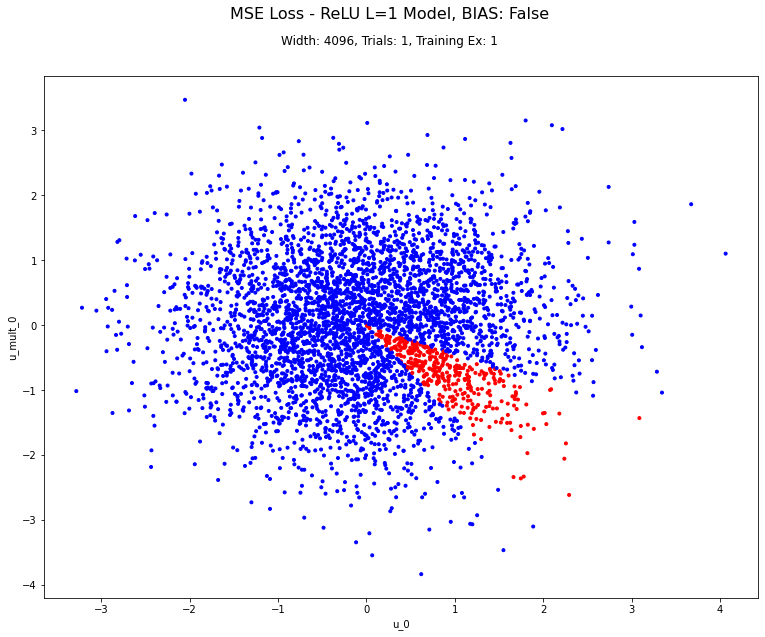

Total Run Time:  0.5109052330008126


In [ ]:
start = timeit.default_timer()

##### Network parameters #####
network_params = {
  'width': 2**12,
  'length': 1,
  'input_dim': 1,
  'output_dim': 1,
  'activation': 'ReLU', # supports 'Identity', 'ReLU', 'Tanh'
  'bias': False,
}

##### Training parameters #####

X = torch.tensor([[1.0]])
y = torch.tensor([[0.0]])
# X = torch.tensor([[1.0], [1.0]])
# y = torch.tensor([1, 0])

train_params = {
  'trials': 1,  # average over this many training_trials
  'loss': 'MSE', # support 'MSE', 'XE'
  'batch_size': X.shape[0],

  'physical_time': False,
  'epochs': 15,
  'physical_time_cap': 1 * network_params['width'],
  'var_lr': False,

  'lr_vals': [4], #np.linspace(4, 30, 10), #[i+5 for i in range(12)],
  'n_train': X.shape[0],

  'w_const': True
}

##### Result parameters #####
result_params = {
  'plots': ['Initial_states'], # supports 'Loss', 'Lambda', 'Dead_neuron_perc', 'Final_DNP', 'Initial_states', 
  # (cont.) 'f0_lam0_alive', 'Network_survival'
  'save_data': False,
  'file_name': 'sep_vs_nonsep/w1024_2in_x1e1-e_y01_e01_phases_200steps',
  'override': False,
}

if result_params['save_data'] and path.exists('data/' + file_name + '.png') and not result_params['override']:
    raise ValueError("File already exists!")

# Reshapes X and y and sends to device
X = X.view(X.shape[0], network_params['input_dim']).to(device)
if train_params['loss'] == 'MSE':
  y = y.view(y.shape[0], network_params['input_dim']).to(device)
elif train_params['loss'] == 'XE':
  y = y.view(y.shape[0]).to(device)
train_data = [X, y]

# Sets parameters to defaults if unspecified above
train_params, network_params = default_params(train_data, train_params, network_params)

test_multiple_lrs(train_data, train_params, network_params, result_params)
# neuron_surivival(train_data, train_params, network_params, result_params)

stop = timeit.default_timer()
print('Total Run Time: ', stop - start)  